# Introduction to stochastic processes and simulation models based on stochastic differential equations

<div class="wrapper">
    <img src="https://iili.io/JTlWuMx.jpg" alt="" width="80" height="80"/>
</div>

#### Simulation Models: <br>
1) Logarithmic Model (Rendleman-Bartter model) <br>
2) Cox-Ingersoll-Ross Model <br>
3) Vasicek Model Simulations <br>
<br>
#### Parameters Assumption:<br>
##### 1) Sample Mean and Sample Var  <br>
    1. Sample <br>
    2. Normalised Sample <br>
    <br>
##### 2) Maximum Likelihood Estimation <br>
    1. Shapiro test for normality ->(non-normal data) <br>
    2. Smirnov test for t-distr ->(non-t-distr data) <br>
    3. Best fitting distr using MLE approach ->(expon, weibull, weibull) <br>
<br>

##### 3) Copulas Approach <br>
    1. Univariate <br>
        a. Best fitting GaussianKDE copula for every asset <br>
        b. MLE param estimation ->(beta, gamma, beta) <br>
    2. Multivariate <br>
        a. GaussianMultivar with univ Beta, GaussKDE, Beta ->(expon, weibull, weibull) <br>
        b. VineCopula Center ->(expon, expon, expon) <br>
        d. VineCopula Regular ->(expon, expon, expon) <br>

<div class="wrapper">
    <img src="https://iili.io/JTlWSVf.jpg" alt="" width="80" height="80"/>
</div>

#### Range Accrual pricing module 

In [1]:
import pandas as pd
import requests

from datetime import datetime
import datetime as dt

import yfinance as yf

import math
import numpy as np

import matplotlib.pyplot as plt 

In [2]:
import math
import random
import decimal
import scipy.linalg
import numpy.random as nrand

## Data downloading

In [3]:
def get_sofr_data():
    r = requests.get('https://markets.newyorkfed.org/read?productCode=50&eventCodes=520&limit=1095&startPosition=0&sort=postDt:-1&format=xlsx'
                    , allow_redirects=True)

    df = pd.read_excel(r.content)
    df = df[['Effective Date', 'Rate (%)']]
    df['Effective Date'] = pd.to_datetime(df['Effective Date'])
    df.columns = ['dt', 'rate']
    return df

In [4]:
def get_ruonia_data():
    y_e = datetime.today().strftime('%Y-%m-%d').split('-')[0]
    m_e = datetime.today().strftime('%Y-%m-%d').split('-')[1]
    d_e = datetime.today().strftime('%Y-%m-%d').split('-')[2]
    
    y_s = (datetime.today() - dt.timedelta(days = 1090)).strftime('%Y-%m-%d').split('-')[0]
    m_s = (datetime.today() - dt.timedelta(days = 1090)).strftime('%Y-%m-%d').split('-')[1]
    d_s = (datetime.today() - dt.timedelta(days = 1090)).strftime('%Y-%m-%d').split('-')[2]

    url = f'https://www.cbr.ru/Queries/UniDbQuery/DownloadExcel/14315?'
    url2 = f'FromDate={m_s}%2F{d_s}%2F{y_s}'
    url3 = f'ToDate={m_e}%2F{d_e}%2F{y_e}'
    url4 = f'posted=False'
    
    r = requests.get(url + url2 + '&' + url3 + '&' + url4
                    , allow_redirects=True)
    
    df = pd.read_excel(r.content)
    df = df[['DT', 'ruo']]
    df['DT'] = pd.to_datetime(df['DT'])
    df.columns = ['dt', 'rate']
    
    return df

In [5]:
def get_currency():
    end = datetime.today().strftime('%Y-%m-%d')
    
    start = (datetime.today() - dt.timedelta(days = 1090)).strftime('%Y-%m-%d')

    df = yf.download('rubusd=X', start, end, group_by = 'column' )
    
    df = df[['Adj Close']].sort_index(ascending=False).reset_index()
    df.columns = ['dt', 'cur']
    df['dt'] = pd.to_datetime(df['dt'])
    
    return df

In [6]:
def get_currency():
    tickers = yf.Tickers('RUBUSD=X')

    df = tickers.tickers['RUBUSD=X'].history(period="48mo")

    df = df[['Close']].sort_index(ascending=False).reset_index()

    df.columns = ['dt', 'cur']

    df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d')
    
    df.index = pd.to_datetime(df['dt'].astype('datetime64[ns]'))
    
    df = df[['cur']]
    
    df = df.reset_index()
    
    return df

In [7]:
def get_itg_data():
    df1 = get_sofr_data()
    df1.index = df1['dt']
    df1 = df1[['rate']]
    df1.columns = ['sofr_rate']

    df2 = get_ruonia_data()
    df2.index = df2['dt']
    df2 = df2[['rate']]
    df2.columns = ['ruonia_rate']

    df3 = get_currency()
    df3.index = df3['dt']
    df3 = df3[['cur']]
    df3.columns = ['currency']

    df = pd.concat([df1, df2, df3], axis=1)
    df = df.dropna()

    return df 

In [8]:
get_itg_data().head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,sofr_rate,ruonia_rate,currency
dt,,,
2020-12-16,0.09,4.32,0.013647
2020-12-17,0.09,4.31,0.013634
2020-12-18,0.09,4.27,0.013682
2020-12-21,0.09,4.27,0.013609
2020-12-22,0.07,4.28,0.013414


## Rendleman-Bartter model

In [9]:
"""
Params:

r0 - interest rate , %
alpha - drift
sigma - volatility
T - granularity of delta T 
N - number of simulated values
"""

def rendleman_bartter(r0, alpha, sigma, T=1., N=10, seed=777):

    np.random.seed(seed)
    dt = T/(N)    
    rates = [r0]
    
    for i in range(N):
        dr = alpha*rates[-1]*dt + \
            sigma*rates[-1]*math.sqrt(dt)*np.random.normal(loc=r0+(alpha-sigma**2/2)
                                                          , scale=sigma)
        
        rates.append(rates[-1] + dr)

    return range(N+1), rates

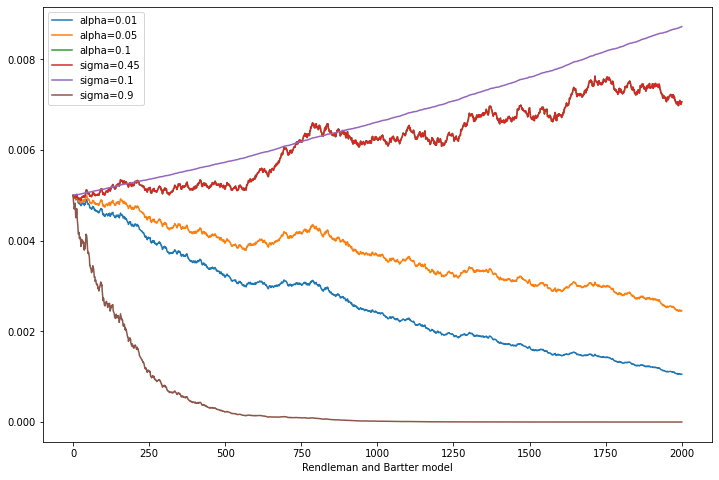

In [10]:
fig = plt.figure(figsize=(12, 8))

for alpha in [0.01, 0.05, 0.1]:
    x, y = rendleman_bartter(r0=0.005
                             , alpha=alpha
                             , sigma=0.45
                             , T=1
                             , N=2000)
    
    plt.plot(x,y, label='alpha=%s'%alpha)
    
for sigma in [0.45, 0.1, 0.9]:
    x, y = rendleman_bartter(r0=0.005
                             , alpha=0.1
                             , sigma=sigma
                             , T=1
                             , N=2000)
    
    plt.plot(x,y, label='sigma=%s'%sigma)

plt.legend(loc='upper left')
plt.xlabel('Rendleman and Bartter model');

## Cox-Ingersoll-Ross Model

##### Brownian Motion Simulations

In [11]:
from math import sqrt
from scipy.stats import norm
import numpy as np

In [12]:
class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self,x0=0):
        """
        Init class
        """
        assert (type(x0)==float or type(x0)==int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_random_walk(self,n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1])
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def gen_normal(self,n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal()
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def stock_price(
                    self,
                    r0=100,
                    alpha=0.2,
                    sigma=0.68,
                    T=52,
                    N=1
                    ):
        """
        Models a stock price S(t) using the Weiner process W(t) as
        `S(t) = S(0).exp{(alpha-(sigma^2/2).t)+sigma.W(t)}`
        
        Arguments:
            r0: Iniital stock price, default 100
            alpha: 'Drift' of the stock (upwards or downwards), default 1
            sigma: 'Volatility' of the stock, default 1
            T: The time period for which the future prices are computed, default 52 (as in 52 weeks)
            N (optional): Number of simulated values
        
        Returns:
            s: A NumPy array with the simulated stock prices over the time-period deltaT
        """
        n_step = int(N)
        time_vector = np.linspace(0,T,num=n_step)
        # Stock variation
        stock_var = (alpha-(sigma**2/2))*time_vector
        # Forcefully set the initial value to zero for the stock price simulation
        self.x0=0
        # Weiner process (calls the `gen_normal` method)
        weiner_process = sigma*self.gen_normal(n_step)
        # Add two time series, take exponent, and multiply by the initial stock price
        s = r0*(np.exp(stock_var+weiner_process))
        
        return s

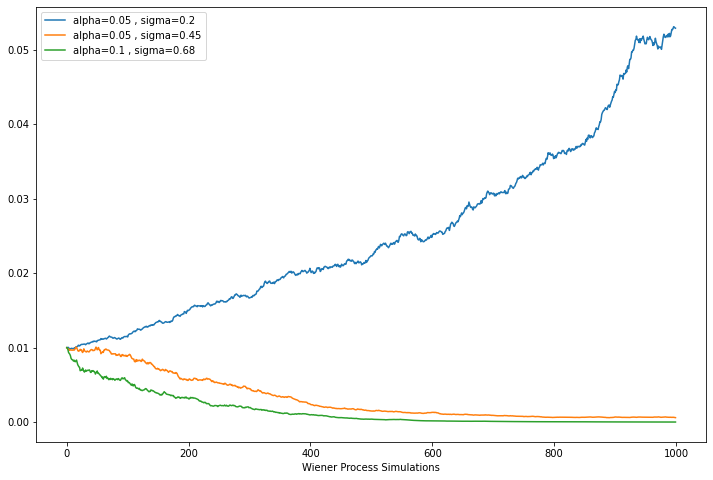

In [13]:
fig = plt.figure(figsize=(12, 8))

b = Brownian()

for alpha, sigma in [(0.05 , 0.2), (0.05, 0.45), (0.1, 0.68)]:
    
    plt.plot(b.stock_price(
                    r0=0.01,
                    alpha=alpha,
                    sigma=sigma,
                    T=52.,
                    N=1000)
             , label=f'alpha={alpha} , sigma={sigma}')
    
plt.legend(loc='upper left')
plt.xlabel('Wiener Process Simulations');

##### Cox-Ingersoll-Ross Model Simulation

In [14]:
def Cox_Ingersoll_Ross(r0, T, N, alpha, beta, sigma, seed=777):
    
    """
        Cox-Ingersoll-Ross Model
        
        Euler-Maruyama approach:
        dr(t) = alpha*(beta - r(t))dt + sigma*√r(t)*dW(t)
        
        Returns
        -------
        Array of simulated interest rates 
        
        Params:
        r0 - start position
        T - step
        N - num of drifts (number of simulated values)
        alpha - regression towards the mean
        beta - drift
        sigma - volatility 
        
    This method returns the rate levels of a mean-reverting cox ingersoll ross process. It is used to model interest
    rates as well as stochastic volatility in the Heston model. Because the returns between the underlying and the
    stochastic volatility should be correlated we pass a correlated Brownian motion process into the method from which
    the interest rate levels are constructed. The other correlated process is used in the Heston model
    :param param: the model parameters object
    :return: the interest rate levels for the CIR process
    """
    
    m = int(T/N)
    
    np.random.seed(seed)
    
    rates = np.zeros(N)
    rates[0] = r0
    
    brownian_motion=np.random.normal(0,1,size=(N))
    
    dt = T/N

    for j in range (1,N):
        dr = alpha*(beta-rates[j-1])*dt + sigma*math.sqrt(rates[j-1])*brownian_motion[j-1]
        rates[j] = max(0, rates[j-1] + dr)
    return rates

Text(0.5, 0, 'Cox-Ingersoll-Ross Model Simulations')

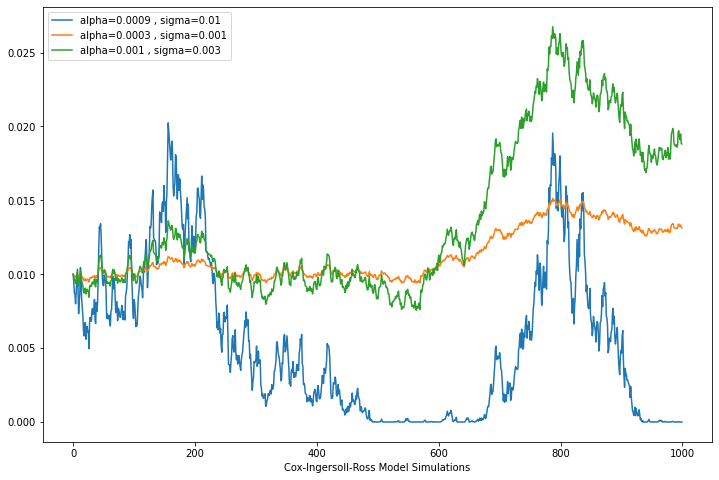

In [15]:
fig = plt.figure(figsize=(12, 8))

for alpha, sigma in [(0.0009 , 0.01), (0.0003, 0.001), (0.001, 0.003)]:

    plt.plot(Cox_Ingersoll_Ross(N=1000, r0=0.01, alpha=alpha, beta=0.01, sigma=sigma, T=52.)
             , label=f'alpha={alpha} , sigma={sigma}')
    
plt.legend(loc='upper left')
plt.xlabel('Cox-Ingersoll-Ross Model Simulations')

#### Logarithmic Model Simulations

In [78]:
"""
Params:

rf - foreign interest rate , %
rd - domestic interest rate , %
alpha - drift
sigma - volatility
T - granularity of delta T 
N - number of simulated values
"""

def logarithmic_model(rf, rd, sigma, T=1., N=10, seed=777):

    np.random.seed(seed)
    dt = T/(N)    
    rates_f = [rf]
    rates_d = [rd]
    
    rates = []
    
    b = Brownian()
    brownian_motion = b.gen_normal(n_step=N)
    
    for i in range(N):
        
        Xt = ((rates_f[-1] - rates_d[-1])*dt + sigma*brownian_motion[i])
        
        rates.append(Xt)

    return rates

Text(0.5, 0, 'Logarithmic Model Simulations')

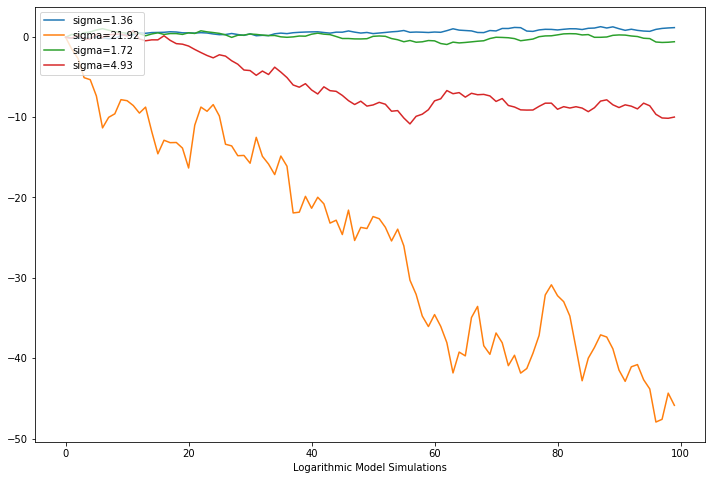

In [17]:
fig = plt.figure(figsize=(12, 8))

for sigma in [1.36, 21.92, 1.72, 4.93]:
    
    y = logarithmic_model(rf=0.49, rd=7.49, sigma=sigma, T=1., N=100, seed=np.random.randint(1,999,1))

    plt.plot(y, label=f'sigma={sigma}')
    
plt.legend(loc='upper left')
             
plt.xlabel('Logarithmic Model Simulations')

##### Vasicek Model Simulations

In [18]:
"""
Vasicek (1977) model
Returns
-------
Array of simulated interest rates 
"""


def vasicek(r0, alpha, beta, sigma, N, T, seed=777):
    if True:
        rates = np.zeros(N)
        
        np.random.seed(seed)
        
        dt = T/float(N)
        
        rates[0] = r0
        
        #b = Brownian()
        #brownian_motion = b.gen_random_walk(N)
        
        brownian_motion=np.random.normal(0,1,size=(N))

        for j in range(1, N):
            rates[j] = rates[j - 1] + alpha*(beta - rates[j - 1])*dt + sigma*brownian_motion[j-1]
            
        return rates  

Text(0.5, 0, 'Vasicek Model Simulations')

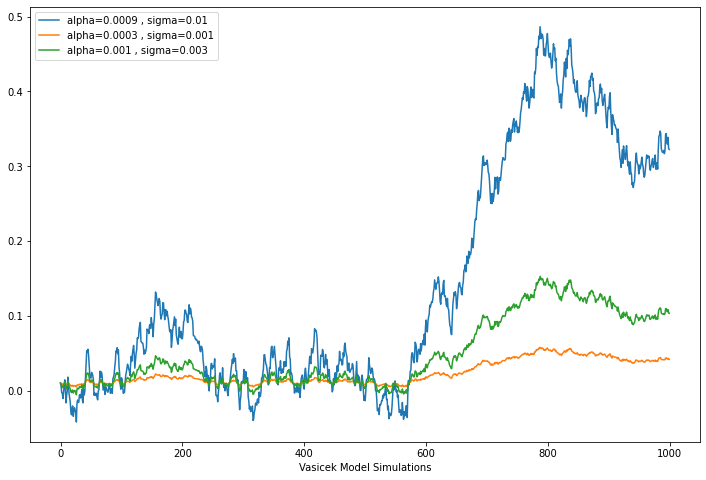

In [19]:
fig = plt.figure(figsize=(12, 8))

for alpha, sigma in [(0.0009 , 0.01), (0.0003, 0.001), (0.001, 0.003)]:

    plt.plot(vasicek(N=1000, r0=0.01, alpha=alpha, beta=0.005, sigma=sigma, T=52.)
             , label=f'alpha={alpha} , sigma={sigma}')
    
plt.legend(loc='upper left')
plt.xlabel('Vasicek Model Simulations')

In [20]:
not_to_del_list = ['not_to_del_list'
, 'get_itg_data'
, 'get_sofr_data'                
, 'get_ruonia_data'                
, 'get_currency'
, 'pd'
,'requests'
,'datetime'
,'dt'
,'yf'
,'math'
,'np'
,'plt' 
,'math'
,'random'
,'decimal'
,'scipy.linalg'
,'norm'
,'nrand'
, 'rendleman_bartter'
, 'Brownian'
, 'Cox_Ingersoll_Ross'
, 'vasicek'
]

In [21]:
xgh = %who_ls
ip=get_ipython()
user_ns=ip.user_ns
for i in xgh:
    if i not in not_to_del_list:
        del user_ns[i]

#### Generate Random Prices of Rates via Cholesky decomposition

In [22]:
df = get_itg_data()
df = df.loc[df.index < '2021-12-10']
df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,sofr_rate,ruonia_rate,currency
dt,,,
2020-12-16,0.09,4.32,0.013647
2020-12-17,0.09,4.31,0.013634
2020-12-18,0.09,4.27,0.013682
2020-12-21,0.09,4.27,0.013609
2020-12-22,0.07,4.28,0.013414


In [23]:
corr_matrix = df.corr()
corr_matrix

,sofr_rate,ruonia_rate,currency
sofr_rate,1.000000,0.332044,0.282860
ruonia_rate,0.332044,1.000000,0.578149
currency,0.282860,0.578149,1.000000


In [24]:
# get random normal distributed values of 2 rates
norm_values = norm.rvs(size=(2, len(df)))

We want to make values from norm_values be correlated so
as our assets are correlated. 

In such case we use $Cholesky$ decomposition:

###### C = LL^T 

, where L - lower triangular matrix

Our Random Values we get as 
###### y = L*x 

and Python implementation: y = np.dot(L, x)

So we get standart normal distributed Values, which are correlated so, as Assets are correlated.

But such Values are N(0, 1) distributed, but we need N(mu_i , sigma_i^2) , where i = 1,2,3 
So we do z = y * sigma + mu

#### For each asset we need to get mu and sigma. There are multiple approaches, how to estimate them:

1) sample mean and sample deviation:
mu_i = sum(df_i)/len(df_i) , sigma_i = ( sum(df_i-μ)² ) / len(df)

2) Maximum Likelihood Estimation:


3) generate synthetic data using Copulas approach:
𝐶(𝑢1, … , 𝑢𝑑) = 𝐹(𝐹1−1(𝑢1), … , 𝐹𝑑−1(𝑢𝑑)).
Here we can generate data for each asset and for multiple assets.



### 1. Sample Mean and Sample Deviation Approach

In [25]:
sma_exv_sofr = np.mean(df['sofr_rate'])
sma_exv_ruon = np.mean(df['ruonia_rate'])
sma_exv_cur = np.mean(df['currency'])

sma_var_sofr = np.var(df['sofr_rate'])
sma_var_ruon = np.var(df['ruonia_rate'])
sma_var_cur = np.var(df['currency'])

Text(0.5, 0, 'Distributions with Sample EV and Var')

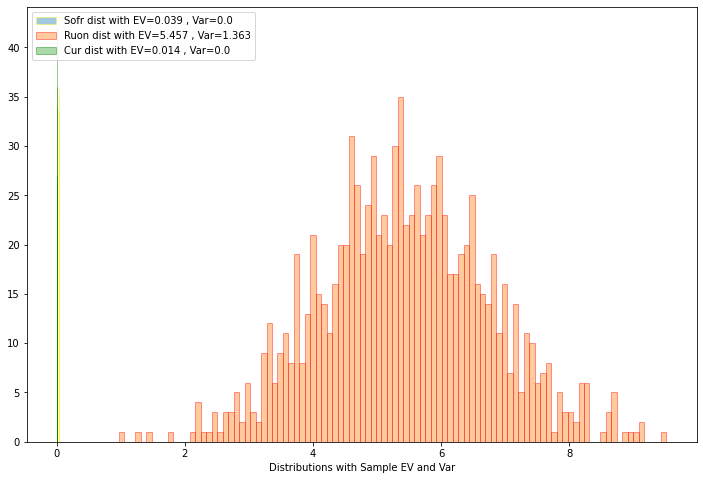

In [26]:
fig = plt.figure(figsize=(12, 8))

plt.hist(np.random.normal(sma_exv_sofr, sma_var_sofr, size=1000), bins=100, alpha=0.4, edgecolor='yellow',
             label=f'Sofr dist with EV={round(sma_exv_sofr,3)} , Var={round(sma_var_sofr,3)}')

plt.hist(np.random.normal(sma_exv_ruon, sma_var_ruon, size=1000), bins=100, alpha=0.4, edgecolor='red',
             label=f'Ruon dist with EV={round(sma_exv_ruon,3)} , Var={round(sma_var_ruon,3)}')

plt.hist(np.random.normal(sma_exv_cur, sma_var_cur, size=1000), bins=100, alpha=0.4, edgecolor='green',
             label=f'Cur dist with EV={round(sma_exv_cur,3)} , Var={round(sma_var_cur,3)}')
    
plt.legend(loc='upper left')
plt.xlabel('Distributions with Sample EV and Var')

Sample Distribution for Sofr and Currency data is extremely low. Thats all because of absolute values of variables. 
We can solve it taking the logarithm 

In [27]:
pd.DataFrame([ np.log(df['sofr_rate'])
              , np.log(df['ruonia_rate'])
             , np.log(df['currency'])
             ]).T.head()

,sofr_rate,ruonia_rate,currency
dt,,,
2020-12-16,-2.407946,1.463255,-4.294267
2020-12-17,-2.407946,1.460938,-4.295214
2020-12-18,-2.407946,1.451614,-4.291697
2020-12-21,-2.407946,1.451614,-4.297027
2020-12-22,-2.659260,1.453953,-4.311488


Let's make data normal

x_new_i = ( x_i - mean(x) ) / var(x)

In [28]:
df_norm_v = pd.DataFrame([ ( np.log(df['sofr_rate']) - np.mean(np.log(df['sofr_rate'])) ) / np.var(np.log(df['sofr_rate']))
              , ( np.log(df['ruonia_rate']) - np.mean(np.log(df['ruonia_rate'])) ) / np.var(np.log(df['ruonia_rate']))
             , ( np.log(df['currency']) - np.mean(np.log(df['currency'])) ) / np.var(np.log(df['currency']))
             ]).T

df_norm_v.head()

,sofr_rate,ruonia_rate,currency
dt,,,
2020-12-16,1.825374,-4.624584,15.002423
2020-12-17,1.825374,-4.675423,12.477340
2020-12-18,1.825374,-4.879964,21.858566
2020-12-21,1.825374,-4.879964,7.641068
2020-12-22,1.391378,-4.828649,-30.932587


In [29]:
print( round(sma_exv_sofr,3) , round(sma_var_sofr,3) )
print( round(sma_exv_ruon,3) , round(sma_var_ruon,3) )
print( round(sma_exv_cur,3) , round(sma_var_cur,3) )

0.039 0.0
5.457 1.363
0.014 0.0


In [30]:
norm_sma_exv_sofr = np.mean(df_norm_v['sofr_rate'])
norm_sma_exv_ruon = np.mean(df_norm_v['ruonia_rate'])
norm_sma_exv_cur = np.mean(df_norm_v['currency'])

norm_sma_var_sofr = np.var(df_norm_v['sofr_rate'])
norm_sma_var_ruon = np.var(df_norm_v['ruonia_rate'])
norm_sma_var_cur = np.var(df_norm_v['currency'])

print( round(norm_sma_exv_sofr,3) , round(norm_sma_var_sofr,3) )
print( round(norm_sma_exv_ruon,3) , round(norm_sma_var_ruon,3) )
print( round(norm_sma_exv_cur,3) , round(norm_sma_var_cur,3) )

0.0 1.727
0.0 21.937
-0.0 2667.503


#### Looks better

Text(0.5, 0, 'Distributions with Normalised Sample EV and Var')

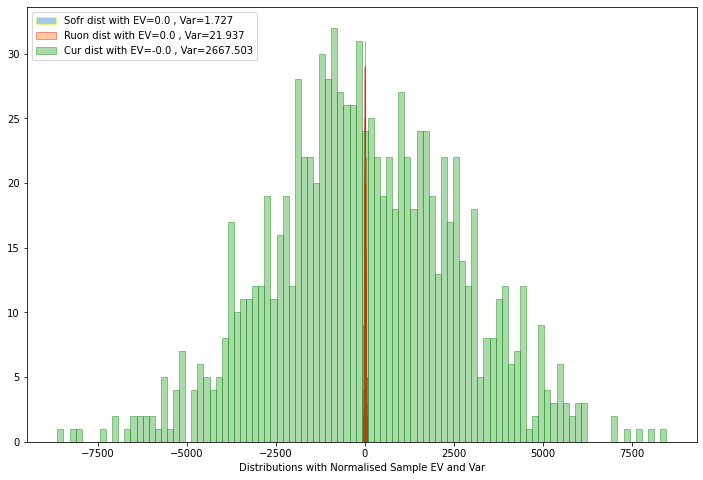

In [31]:
fig = plt.figure(figsize=(12, 8))

plt.hist(np.random.normal(norm_sma_exv_sofr, norm_sma_var_sofr, size=1000), bins=100, alpha=0.4, edgecolor='yellow',
             label=f'Sofr dist with EV={round(norm_sma_exv_sofr,3)} , Var={round(norm_sma_var_sofr,3)}')

plt.hist(np.random.normal(norm_sma_exv_ruon, norm_sma_var_ruon, size=1000), bins=100, alpha=0.4, edgecolor='red',
             label=f'Ruon dist with EV={round(norm_sma_exv_ruon,3)} , Var={round(norm_sma_var_ruon,3)}')

plt.hist(np.random.normal(norm_sma_exv_cur, norm_sma_var_cur, size=1000), bins=100, alpha=0.4, edgecolor='green',
             label=f'Cur dist with EV={round(norm_sma_exv_cur,3)} , Var={round(norm_sma_var_cur,3)}')
    
plt.legend(loc='upper left')
plt.xlabel('Distributions with Normalised Sample EV and Var')

In [32]:
sample_dist_results = pd.DataFrame([['sofr_rate', sma_exv_sofr, sma_var_sofr]
                                   , ['ruonia_rate', sma_exv_ruon, sma_var_ruon]
                                    , ['sofr_rate', sma_exv_cur, sma_var_cur]]
                                  , columns=['asset', 'expected_value', 'variance'])

sample_dist_results

,asset,expected_value,variance
0,sofr_rate,0.039483,4.842152e-04
1,ruonia_rate,5.456940,1.362601e+00
2,sofr_rate,0.013573,6.912439e-08


In [33]:
sample_dist_normalized_results = pd.DataFrame([['sofr_rate', norm_sma_exv_sofr, norm_sma_var_sofr]
                                   , ['ruonia_rate', norm_sma_exv_ruon, norm_sma_var_ruon]
                                    , ['sofr_rate', norm_sma_exv_cur, norm_sma_var_cur]]
                                  , columns=['asset', 'expected_value', 'variance'])

sample_dist_normalized_results

,asset,expected_value,variance
0,sofr_rate,0.000000e+00,1.726904
1,ruonia_rate,2.205133e-15,21.936860
2,sofr_rate,-9.388965e-13,2667.502629


In [34]:
df_norm_v.corr()

,sofr_rate,ruonia_rate,currency
sofr_rate,1.000000,0.449949,0.357778
ruonia_rate,0.449949,1.000000,0.576519
currency,0.357778,0.576519,1.000000


In [35]:
df.corr()

,sofr_rate,ruonia_rate,currency
sofr_rate,1.000000,0.332044,0.282860
ruonia_rate,0.332044,1.000000,0.578149
currency,0.282860,0.578149,1.000000


In [36]:
sample_res = {'sample_dist_results': sample_dist_results
             , 'sample_dist_results_corr': df.corr()
             
             , 'sample_dist_normalized_results': sample_dist_normalized_results
             , 'sample_dist_normalized_results_corr': df_norm_v.corr()}

In [37]:
for i in ['df'
, 'sample_res'
         ,'user_ns']:
    not_to_del_list.append(i)

xgh = %who_ls
ip=get_ipython()

user_ns = ip.user_ns

for i in xgh:
    if i not in not_to_del_list:
        del user_ns[i]

As we can see, there is non linear correlation between asset values. 
We can try Maximum Likelihood Estimation

### 2. Maximum Likelihood Estimation

##### Shapiro Test 

In [38]:
from scipy.stats import norm, shapiro
from scipy.stats import t
import seaborn as sns

In [39]:
for item in df.columns.values:
    print(shapiro(df[item].values))

ShapiroResult(statistic=0.8153823018074036, pvalue=6.938436506115711e-16)
ShapiroResult(statistic=0.8995908498764038, pvalue=2.4361018410856694e-11)
ShapiroResult(statistic=0.98287034034729, pvalue=0.006652779411524534)


##### Values are far from Normal . Lets try to approximate adding t-distribution

In [40]:
t_parameters = []
norm_parameters = []

for item in df.columns.values:
    t_parameters.append(t.fit(df[item].values))
    norm_parameters.append(norm.fit(df[item].values))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

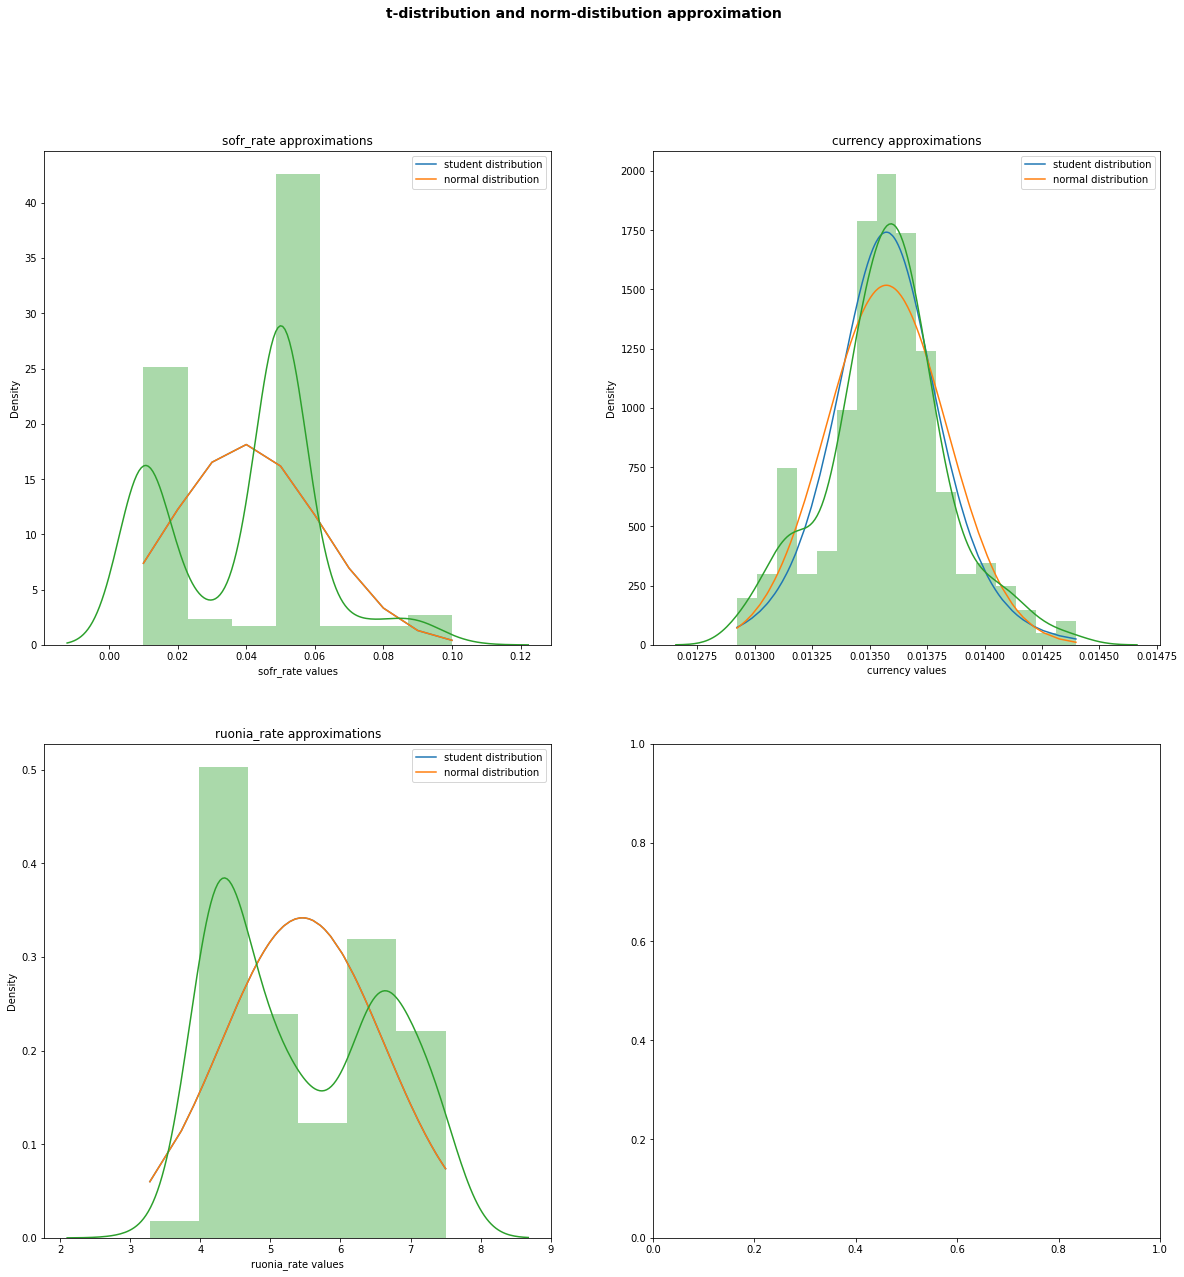

In [41]:
num_stocks = len(list(df.columns))

num_rows = int(np.ceil(num_stocks/2))
fig, axs = plt.subplots(num_rows, 2, figsize=(20, 20))

fig.suptitle('t-distribution and norm-distibution approximation', fontsize=14, fontweight='bold')

for i, item in enumerate(df.columns.values):

    axs[i%num_rows, i//num_rows].plot(sorted(df[item].values)
                                      , t.pdf(sorted(df[item].values)
                                                , t_parameters[i][0]
                                              , t_parameters[i][1]
                                              , t_parameters[i][2])
                                      , label = 'student distribution')
    
    axs[i%num_rows, i//num_rows].plot(sorted(df[item].values)
                                      , norm.pdf(sorted(df[item].values)
                                                 , norm_parameters[i][0]
                                                 , norm_parameters[i][1])
                                      , label = 'normal distribution')
    
    sns.distplot(df[item].values, kde = True, ax=axs[i%num_rows, i//num_rows]);
    
    axs[i%num_rows, i//num_rows].set_title(f"{item} approximations")
    axs[i%num_rows, i//num_rows].set_xlabel(f'{item} values')
    axs[i%num_rows, i//num_rows].set_ylabel('Density')
    axs[i%num_rows, i//num_rows].legend()



plt.show()

#### As we can see, data is far from normal, but it might be t-distributed
#### We can do a Smirnov test to proove t-distribution

In [42]:
from scipy import stats

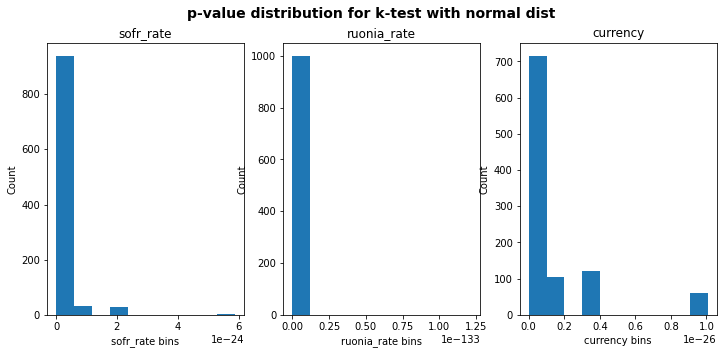

In [43]:
# k-test for normal distr
pv_itg_norm = []

for item in df.columns.values:
    pre = []
    s = len(df[item]*10)
    for i in range(0,1000):
        x = np.random.normal(size=s)
        pre.append(stats.kstest(df[item].values, x).pvalue)
    pv_itg_norm.append(pre)
    
    
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle('p-value distribution for k-test with normal dist', fontsize=14, fontweight='bold')

for i, item in enumerate(df.columns.values):
    counts, bins = np.histogram((pv_itg_norm[i]))
    axs[i].hist(pv_itg_norm[i])
    axs[i].set_title(f"{item}")
    axs[i].set_xlabel(f'{item} bins')
    axs[i].set_ylabel('Count')

plt.show()

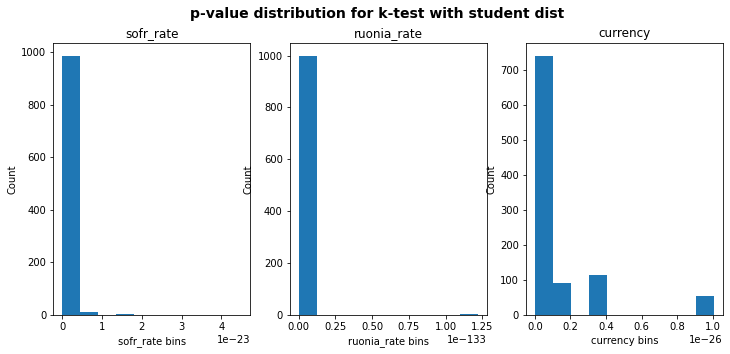

In [44]:
# k-test for student distr
pv_itg_norm = []

for item in df.columns.values:
    pre = []
    s = len(df[item]*10)
    for i in range(0,1000):
        x = np.random.standard_t(df=len(df), size=s)
        pre.append(stats.kstest(df[item].values, x).pvalue)
    pv_itg_norm.append(pre)
    
    
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle('p-value distribution for k-test with student dist', fontsize=14, fontweight='bold')

for i, item in enumerate(df.columns.values):
    counts, bins = np.histogram((pv_itg_norm[i]))
    axs[i].hist(pv_itg_norm[i])
    axs[i].set_title(f"{item}")
    axs[i].set_xlabel(f'{item} bins')
    axs[i].set_ylabel('Count')

plt.show()

As we can see, p-value is distributed non uniformly for two tests.

Our data is neither of two tested: normal, student 

We can try distfit library 

In [45]:
#pip install distfit

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 2241.03] [loc=0.039 scale=0.022]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 2199.06] [loc=0.010 scale=0.029]
[distfit] >INFO> [pareto    ] [0.12 sec] [RSS: 2235.91] [loc=-0.025 scale=0.035]
[distfit] >INFO> [dweibull  ] [0.09 sec] [RSS: 2410.21] [loc=0.050 scale=0.014]
[distfit] >INFO> [t         ] [0.13 sec] [RSS: 2241.04] [loc=0.039 scale=0.022]
[distfit] >INFO> [genextreme] [0.38 sec] [RSS: 2255.82] [loc=0.031 scale=0.022]
[distfit] >INFO> [gamma     ] [0.18 sec] [RSS: 2241.05] [loc=-2.472 scale=0.000]
[distfit] >INFO> [lognorm   ] [0.09 sec] [RSS: 2276.48] [loc=0.002 scale=0.029]
[distfit] >INFO> [beta      ] [0.12 sec] [RSS: 2886.69] [loc=0.010 scale=0.168]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 2622.17] [loc=0.010 scale=0.090]
[distfit] >INFO> [loggamma  ] [0.11 sec] [RSS: 2241.55] [loc=-4.435 scale=0.659]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] 

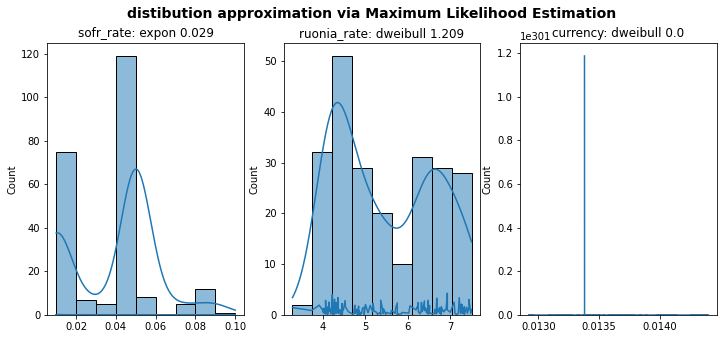

In [46]:
from distfit import distfit

dist = distfit()
d = {}

fig, axs = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle('distibution approximation via Maximum Likelihood Estimation', fontsize=14, fontweight='bold')

for i, item in enumerate(df.columns.values):
    
    x = dist.fit_transform(df[item])
    d[item] = [item
              , x['model']['name']
              , x['model']['loc']
              , x['model']['scale']
              , x['model']['params']]
    
    axs[i].set_title(f"{item}"+': '+x['model']['name']+' '+str(round(x['model']['scale'],3)))
    
    if x['model']['name'] == 'expon':
        axs[i].plot(sorted(df[item].values)
                    , np.random.exponential(float(x['model']['scale']), size=len(df))
                    , label = 'Exponential distribution')
        sns.histplot(df[item].values, kde = True, ax=axs[i])
        
    elif x['model']['name'] == 'dweibull':# and item == 'ruonia_rate':
        axs[i].plot(sorted(df[item].values)
                    , np.random.weibull(float(x['model']['scale']), size=len(df))
                    , label = 'Weibull distribution')
        sns.histplot(df[item].values, kde = True, ax=axs[i])
        
plt.show()

In [47]:
mle_results = pd.DataFrame([d['sofr_rate'], d['ruonia_rate'], d['currency']]
            , columns=['value', 'distribution', 'loc', 'scale', 'params'])
mle_results

,value,distribution,loc,scale,params
0,sofr_rate,expon,0.01000,0.029483,"(0.01, 0.029482758620689657)"
1,ruonia_rate,dweibull,5.65108,1.208550,"(2.3274488596444587, 5.651080225681783, 1.2085..."
2,currency,dweibull,0.01359,0.000203,"(1.0845673349247233, 0.013589536547462833, 0.0..."


In [48]:
mle_sofr_exp = np.random.exponential(scale=mle_results['scale'][0]
                                     , size=len(df))
mle_ruonia_exp = np.random.weibull(a=mle_results['scale'][1]
                                     , size=len(df))
mle_currency_exp = np.random.weibull(a=mle_results['scale'][2]+1
                                     , size=len(df))

mle_results_corr = pd.DataFrame(np.array([mle_sofr_exp
        , mle_ruonia_exp
        , mle_currency_exp]).T).corr()

mle_results_corr

,0,1,2
0,1.000000,-0.030044,0.076311
1,-0.030044,1.000000,0.017345
2,0.076311,0.017345,1.000000


In [49]:
mle_res = {'mle_results': mle_results
             , 'mle_results_corr': df.corr()}

In [50]:
for i in ['norm',
'shapiro',
't',
'sns',
'stats',
'distfit',
'mle_res',
't_parameters',
'user_ns']:
    not_to_del_list.append(i)

xgh = %who_ls
ip=get_ipython()

user_ns=ip.user_ns

for i in xgh:
    if i not in not_to_del_list:
        del user_ns[i]

### 3. Copula Approach

In [51]:
#pip install copulae
#pip install copulas

In [52]:
import copulae

In [53]:
from copulas.univariate import Univariate

### Univariate case

#### Fit whick copula to use for each asset

In [54]:
univariate = Univariate()

for i in df.columns.values:
    univariate.fit(df[i])
    print(univariate.to_dict()['type'])

copulas.univariate.gaussian_kde.GaussianKDE
copulas.univariate.gaussian_kde.GaussianKDE
copulas.univariate.gaussian_kde.GaussianKDE


#### Add some synthetic data

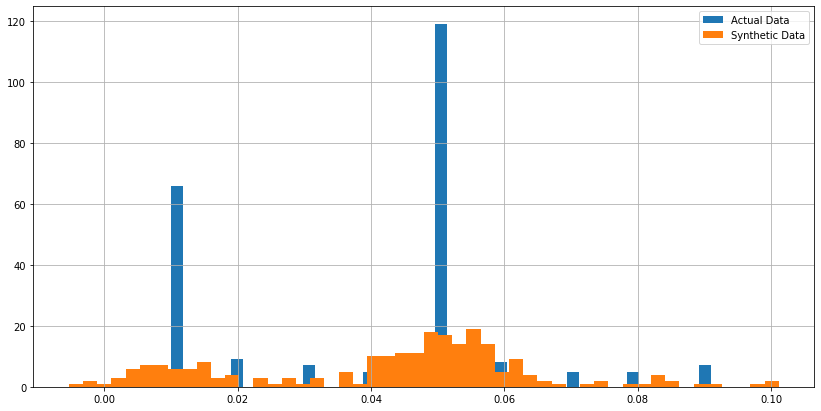

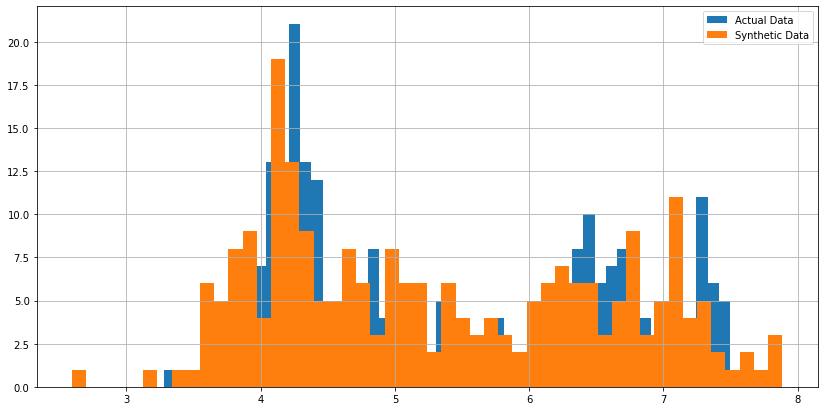

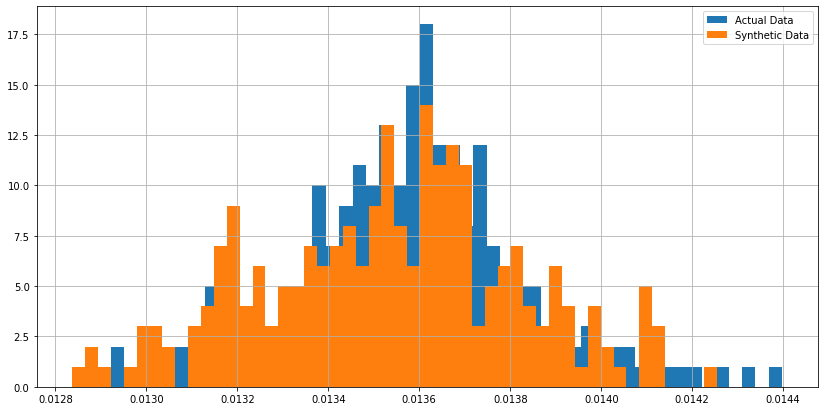

In [55]:
for item in ['sofr_rate', 'ruonia_rate', 'currency']:
    data = df[item]

    univariate = Univariate()
    univariate.fit(data)
    parameters = univariate.to_dict()['type']
    synth_data = univariate.sample(len(df))

    plt.figure(figsize=(14, 7))
    data.hist(bins=50, label = 'Actual Data')
    pd.Series(synth_data).hist(bins=50, label = 'Synthetic Data')
    plt.legend()

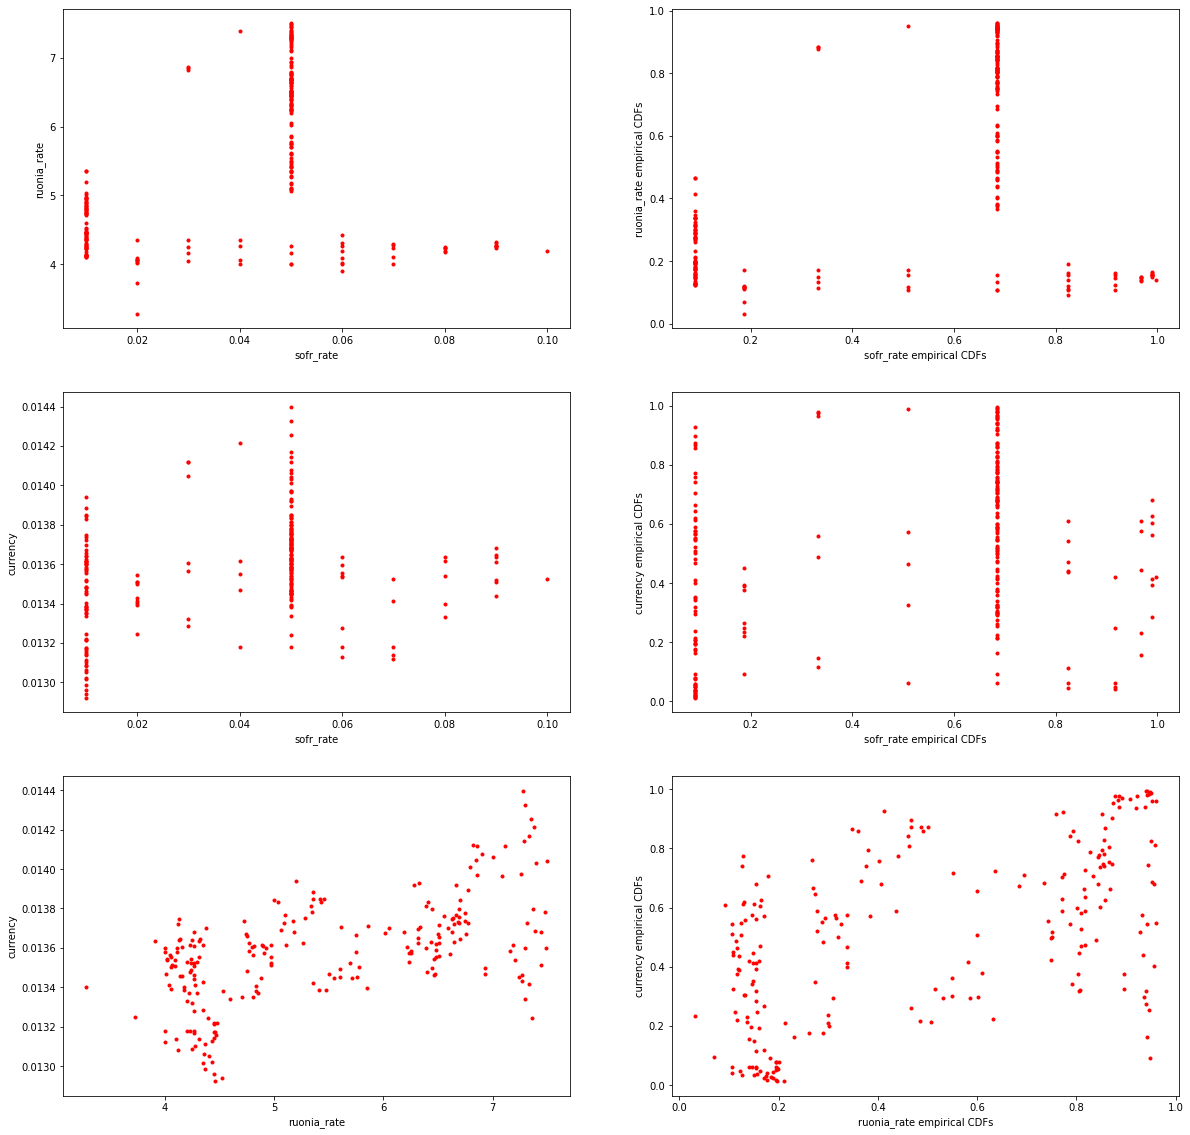

In [56]:
row_num = 0
fig, axs = plt.subplots(3, 2, figsize=(20, 20))


for i, item in enumerate(df.columns.values):
    for j in range(i, len(df.columns.values)):
        if i != j:
            axs[row_num, 0].plot(df.iloc[:,i].values
                                 , df.iloc[:,j].values, "r.")
            axs[row_num, 0].set_xlabel(f'{df.columns.values[i]}')
            axs[row_num, 0].set_ylabel(f'{df.columns.values[j]}')

            axs[row_num, 1].plot(t.cdf(df.iloc[:,i].values
                                       , t_parameters[i][0]
                                       , t_parameters[i][1]
                                       , t_parameters[i][2])
                                 , t.cdf(df.iloc[:,j].values
                                         , t_parameters[j][0]
                                         , t_parameters[j][1]
                                         , t_parameters[j][2]), "r.")
            axs[row_num, 1].set_xlabel(f'{df.columns.values[i]} empirical CDFs')
            axs[row_num, 1].set_ylabel(f'{df.columns.values[j]} empirical CDFs')
            row_num = row_num + 1

plt.show()

##### Plot synhtetic data

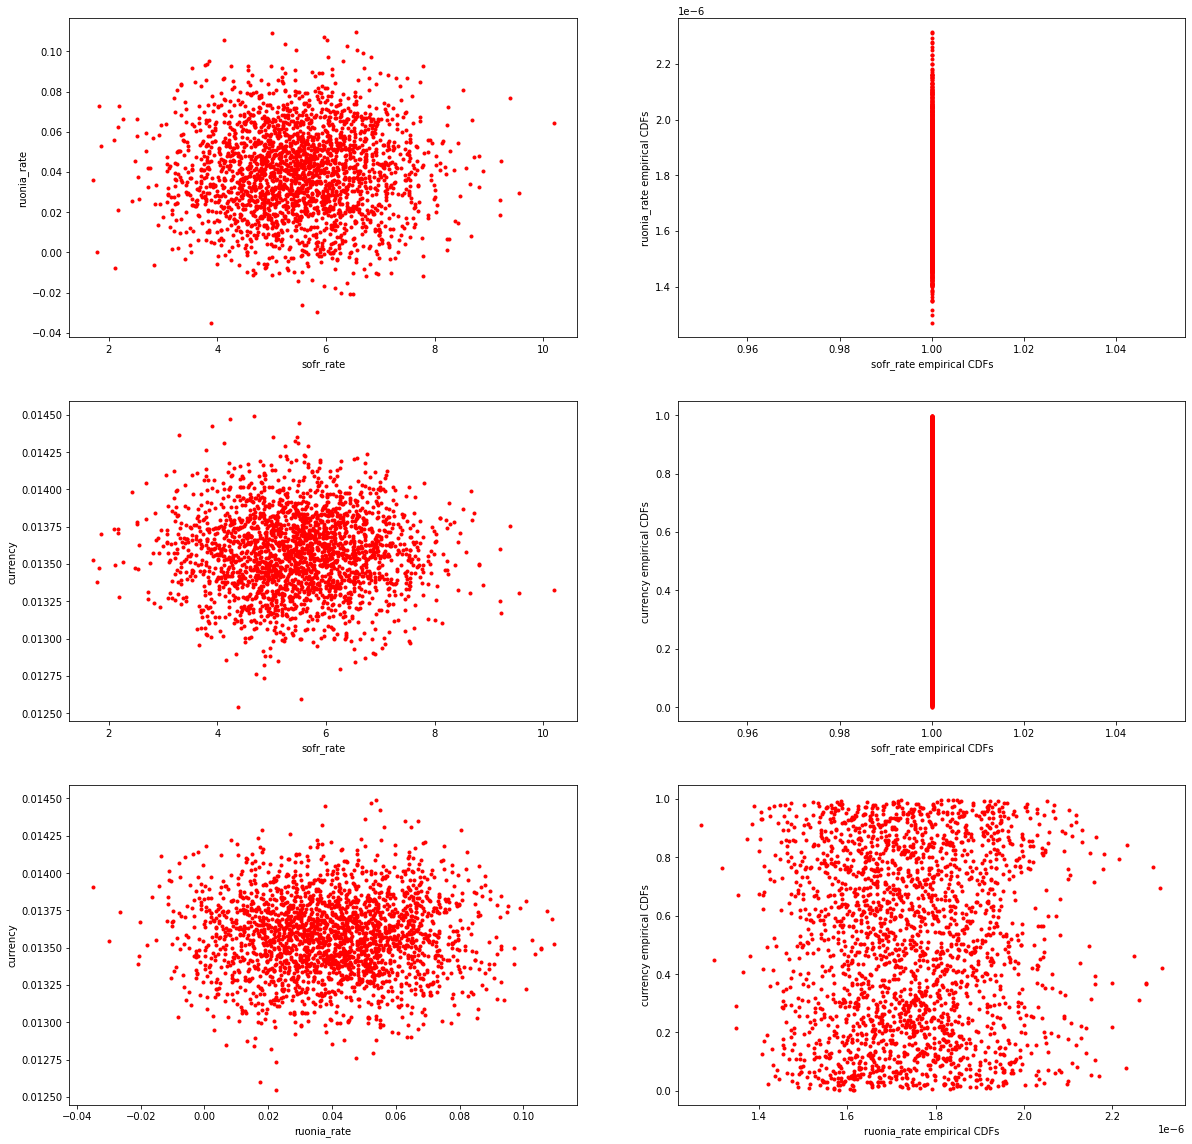

In [57]:
from copulas.univariate import GaussianUnivariate

row_num = 0
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

dist = GaussianUnivariate()

dist.fit(df['ruonia_rate'])
ruonia_s = dist.sample(len(df)*10)

dist.fit(df['sofr_rate'])
sofr_s = dist.sample(len(df)*10)

dist.fit(df['currency'])
curr_s = dist.sample(len(df)*10)

s_data = [ruonia_s, sofr_s, curr_s]

for i, item in enumerate(df.columns.values):
    for j in range(i, len(df.columns.values)):
        if i != j:
            axs[row_num, 0].plot(s_data[i]
                                 , s_data[j], "r.")
            axs[row_num, 0].set_xlabel(f'{df.columns.values[i]}')
            axs[row_num, 0].set_ylabel(f'{df.columns.values[j]}')

            axs[row_num, 1].plot(t.cdf(s_data[i]
                                       , t_parameters[i][0]
                                       , t_parameters[i][1]
                                       , t_parameters[i][2])
                                 , t.cdf(s_data[j]
                                         , t_parameters[j][0]
                                         , t_parameters[j][1]
                                         , t_parameters[j][2]), "r.")
            axs[row_num, 1].set_xlabel(f'{df.columns.values[i]} empirical CDFs')
            axs[row_num, 1].set_ylabel(f'{df.columns.values[j]} empirical CDFs')
            row_num = row_num + 1

plt.show()

#### For every asset fit copula, get synthetic data and do MLE tests 

In [58]:
dist = distfit()
d = {}
x = []
for i, item in enumerate(s_data):
    
    x.append(dist.fit_transform(item))
    


[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 0.005932] [loc=5.485 scale=1.155]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 0.757475] [loc=1.702 scale=3.782]
[distfit] >INFO> [pareto    ] [0.08 sec] [RSS: 1.19867] [loc=-0.001 scale=1.703]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 0.0545963] [loc=5.482 scale=0.981]
[distfit] >INFO> [t         ] [0.12 sec] [RSS: 0.00595469] [loc=5.483 scale=1.127]
[distfit] >INFO> [genextreme] [0.11 sec] [RSS: 0.0121387] [loc=5.036 scale=1.140]
[distfit] >INFO> [gamma     ] [0.11 sec] [RSS: 0.00599568] [loc=-34.629 scale=0.033]
[distfit] >INFO> [lognorm   ] [0.23 sec] [RSS: 0.0059889] [loc=-55.515 scale=60.989]
[distfit] >INFO> [beta      ] [0.09 sec] [RSS: 0.00646599] [loc=-14.409 scale=1310615.051]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 0.563032] [loc=1.702 scale=8.492]
[distfit] >INFO> [loggamma  ] [0.11 sec] [RSS: 0.0061286] [loc=-272.489 scale=39.423]
[distfit] >INFO> Compute confidenc

In [59]:
data = [
    ['sofr_rate'
         , x[0]['model']['name']
         , x[0]['model']['loc']
         , x[0]['model']['scale']
         , x[0]['model']['arg']]
    , ['ruonia_rate'
         , x[1]['model']['name']
         , x[1]['model']['loc']
         , x[1]['model']['scale']
         , x[1]['model']['arg']]
    , ['currency'
         , x[2]['model']['name']
         , x[2]['model']['score']
         , x[2]['model']['loc']
         , x[2]['model']['scale']
         , x[2]['model']['arg']]
    ]
    
        
c_u_results = pd.DataFrame(data)
c_u_results

,0,1,2,3,4,5
0,sofr_rate,norm,5.484899,1.155436,(),None
1,ruonia_rate,beta,-0.082478,0.257494,"(15.64327461514221, 17.289706017151993)",None
2,currency,t,84514.142419,0.013576,0.000259,"(45.98545996573996,)"


In [60]:
c_u_results_corr = pd.DataFrame(np.array(s_data).T, columns=['sofr_rate'
                                         , 'ruonia_rate'
                                         , 'currency']).corr()
c_u_results_corr

,sofr_rate,ruonia_rate,currency
sofr_rate,1.000000,-0.003647,-0.011999
ruonia_rate,-0.003647,1.000000,0.007436
currency,-0.011999,0.007436,1.000000


In [61]:
c_u_res = {'c_u_results': c_u_results
          , 'c_u_results': c_u_results_corr}

In [62]:
for i in [
    'c_u_res'
    , 'copulae'
    , 'Univariate'
    , 'GaussianUnivariate'
]:
    not_to_del_list.append(i)

xgh = %who_ls
ip=get_ipython()

user_ns=ip.user_ns

for i in xgh:
    if i not in not_to_del_list:
        del user_ns[i]

#### Copulas Multivariate Approach

##### For Gaussian Copula  specify distr manually 
##### For others - such distr, thats fits best

[distfit] >INFO> Fitting GaussianMultivariate(distribution="{'x': <class 'copulas.univariate.beta.BetaUnivariate'>, 'y': <class 'copulas.univariate.gaussian_kde.GaussianKDE'>, 'z': <class 'copulas.univariate.beta.BetaUnivariate'>}")
[distfit] >INFO> Fitting VineCopula("center")
[distfit] >INFO> Fitting VineCopula("direct")
[distfit] >INFO> Fitting VineCopula("regular")


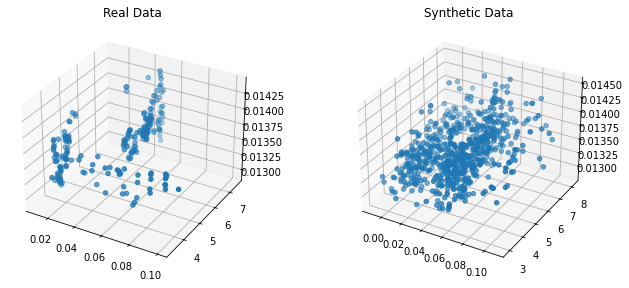

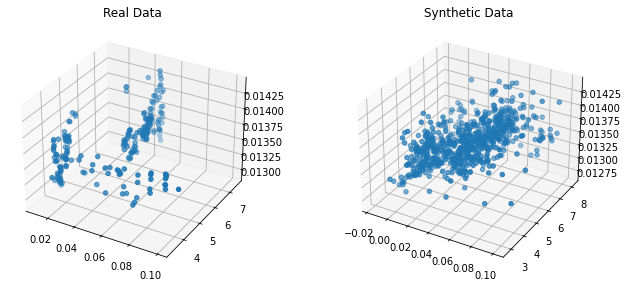

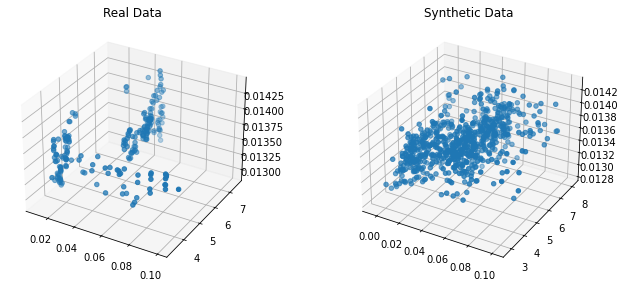

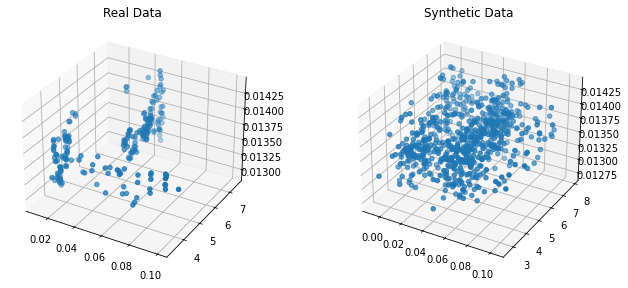

In [63]:
from copulas.univariate import BetaUnivariate, GaussianKDE, GaussianUnivariate
from copulas.multivariate import GaussianMultivariate
from copulas.multivariate import VineCopula

from copulas.visualization import compare_3d

c_m_res = {}

copula = GaussianMultivariate(distribution={
    "x": BetaUnivariate,
    "y": GaussianKDE,
    "z": BetaUnivariate})
copula.fit(df)
synthetic_data = copula.sample(len(df)*3)
compare_3d(df, synthetic_data)
c_m_res['GaussianMultivariate'] = copula.to_dict()

copula = VineCopula('center')
copula.fit(df)
synthetic_data = copula.sample(len(df)*3)
compare_3d(df, synthetic_data)
c_m_res['VineCopulaCenter'] = copula.to_dict()

copula = VineCopula('direct')
copula.fit(df)
synthetic_data = copula.sample(len(df)*3)
compare_3d(df, synthetic_data)
c_m_res['VineCopulaDirect'] = copula.to_dict()

copula = VineCopula('regular')
copula.fit(df)
synthetic_data = copula.sample(len(df)*3)
compare_3d(df, synthetic_data)
c_m_res['VineCopulaRegular'] = copula.to_dict()

In [64]:
def get_params(s_data):
    dist = distfit()
    d = {}
    x = []
    for i, item in enumerate(s_data):

        x.append(dist.fit_transform(item))
    data = [
    ['sofr_rate'
         , x[0]['model']['name']
         , x[0]['model']['loc']
         , x[0]['model']['scale']
         , x[0]['model']['arg']]
    , ['ruonia_rate'
         , x[1]['model']['name']
         , x[1]['model']['loc']
         , x[1]['model']['scale']
         , x[1]['model']['arg']]
    , ['currency'
         , x[2]['model']['name']
         , x[2]['model']['score']
         , x[2]['model']['loc']
         , x[2]['model']['scale']
         , x[2]['model']['arg']]
    ]
    return data

In [65]:
s_data = [np.array(c_m_res['GaussianMultivariate']['univariates'][0]['dataset'])
            ,np.array(c_m_res['GaussianMultivariate']['univariates'][1]['dataset'])
            ,np.array(c_m_res['GaussianMultivariate']['univariates'][2]['dataset'])]
x = get_params(s_data)
c_m_res_gaus = {'GaussianMultivariate': pd.DataFrame(x)
                , 'GaussianMultivariateCorr': pd.DataFrame(c_m_res['GaussianMultivariate']['covariance'])
}



s_data = [np.array(c_m_res['VineCopulaCenter']['unis'][0]['dataset'])
            ,np.array(c_m_res['VineCopulaCenter']['unis'][0]['dataset'])
            ,np.array(c_m_res['VineCopulaCenter']['unis'][0]['dataset'])]
x = get_params(s_data)
c_m_res_gaus['VineCopulaCenter'] = pd.DataFrame(x)
c_m_res_gaus['VineCopulaCenterCorr'] = pd.DataFrame(c_m_res['VineCopulaCenter']['tau_mat'])




s_data = [np.array(c_m_res['VineCopulaDirect']['unis'][0]['dataset'])
            ,np.array(c_m_res['VineCopulaDirect']['unis'][0]['dataset'])
            ,np.array(c_m_res['VineCopulaDirect']['unis'][0]['dataset'])]
x = get_params(s_data)
c_m_res_gaus['VineCopulaDirect'] = pd.DataFrame(x)
c_m_res_gaus['VineCopulaDirect'] = pd.DataFrame(c_m_res['VineCopulaDirect']['tau_mat'])



s_data = [np.array(c_m_res['VineCopulaRegular']['unis'][0]['dataset'])
            ,np.array(c_m_res['VineCopulaRegular']['unis'][0]['dataset'])
            ,np.array(c_m_res['VineCopulaRegular']['unis'][0]['dataset'])]
x = get_params(s_data)
c_m_res_gaus['VineCopulaRegular'] = pd.DataFrame(x)
c_m_res_gaus['VineCopulaRegularCorr'] = pd.DataFrame(c_m_res['VineCopulaRegular']['tau_mat'])

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 2241.03] [loc=0.039 scale=0.022]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 2199.06] [loc=0.010 scale=0.029]
[distfit] >INFO> [pareto    ] [0.11 sec] [RSS: 2235.91] [loc=-0.025 scale=0.035]
[distfit] >INFO> [dweibull  ] [0.06 sec] [RSS: 2410.21] [loc=0.050 scale=0.014]
[distfit] >INFO> [t         ] [0.12 sec] [RSS: 2241.04] [loc=0.039 scale=0.022]
[distfit] >INFO> [genextreme] [0.16 sec] [RSS: 2255.82] [loc=0.031 scale=0.022]
[distfit] >INFO> [gamma     ] [0.08 sec] [RSS: 2241.05] [loc=-2.472 scale=0.000]
[distfit] >INFO> [lognorm   ] [0.07 sec] [RSS: 2276.48] [loc=0.002 scale=0.029]
[distfit] >INFO> [beta      ] [0.11 sec] [RSS: 2886.69] [loc=0.010 scale=0.168]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 2622.17] [loc=0.010 scale=0.090]
[distfit] >INFO> [loggamma  ] [0.11 sec] [RSS: 2241.55] [loc=-4.435 scale=0.659]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] 

[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Cleaning previous fitted model results.
[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 2241.03] [loc=0.039 scale=0.022]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 2199.06] [loc=0.010 scale=0.029]
[distfit] >INFO> [pareto    ] [0.08 sec] [RSS: 2235.91] [loc=-0.025 scale=0.035]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 2410.21] [loc=0.050 scale=0.014]
[distfit] >INFO> [t         ] [0.10 sec] [RSS: 2241.04] [loc=0.039 scale=0.022]
[distfit] >INFO> [genextreme] [0.15 sec] [RSS: 2255.82] [loc=0.031 scale=0.022]
[distfit] >INFO> [gamma     ] [0.08 sec] [RSS: 2241.05] [loc=-2.472 scale=0.000]
[distfit] >INFO> [lognorm   ] [0.05 sec] [RSS: 2276.48] [loc=0.002 scale=0.029]
[distfit] >INFO> [beta      ] [0.10 sec] [RSS: 2886.69] [loc=0.010 scale=0.168]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 2622.17] [loc=0.010 scale=0.090]
[distfit] >INFO> [loggamma  ] [0.1

In [66]:
for i in [
    'c_m_res_gaus'
]:
    not_to_del_list.append(i)

xgh = %who_ls
ip=get_ipython()

user_ns=ip.user_ns

for i in xgh:
    if i not in not_to_del_list:
        del user_ns[i]

### Range Accrual pricing module

In [67]:
res = [sample_res, mle_res, c_u_res, c_m_res_gaus]

In [68]:
df.tail(1)

,sofr_rate,ruonia_rate,currency
dt,,,
2021-12-09,0.05,7.49,0.013601


In [69]:
r0_sofr = 0.05
r0_ruonia = 7.49
r0_currency = 0.013601

#### Sample Approaches

In [70]:
print("Expected Value")
print(res[0]['sample_dist_results'].iat[1,1]) 
print("")
print("Variance")
print(res[0]['sample_dist_results'].iat[1,2])

Expected Value
5.4569396551724125

Variance
1.3626005480826398


In [71]:
res[0]['sample_dist_results']

,asset,expected_value,variance
0,sofr_rate,0.039483,4.842152e-04
1,ruonia_rate,5.456940,1.362601e+00
2,sofr_rate,0.013573,6.912439e-08


In [125]:
def get_range_accr_price(
    upper_bound=8
    , low_bound=None
    , nominal=1000
    ,start='2020-12-15'
    ,end= '2021-12-31'
    
    , gran='hour'
    , res=res
    , appr=None
    , sim_num=1000
    , model='logarithmic_model'
    , data=df

    , plot_show=False): 
    
    delta = (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1, 'D')
    if gran == 'hour':
        N = int(delta*24)
    elif gran == 'day':
        N = int(delta)
    elif gran == 'minute':
        N = int(delta*24*60)
    
    T = 1.
    rf = df.tail(1)['sofr_rate'][0]
    rd = df.tail(1)['ruonia_rate'][0]
    
    if appr==None:
        beta=1
        alpha = res[0]['sample_dist_results']['expected_value'][1]
        sigma = res[0]['sample_dist_results']['variance'][1]
    
    exp_v_sims = []
    
    if model == 'rendleman_bartter':
        for _ in range(0, sim_num):
            s = rendleman_bartter(r0=rd
                              , alpha=alpha
                              , sigma=sigma
                             , T=T
                              , N=N
                              , seed=random.randint(1, 999))[1]
            exp_v_sims.append(s)
            
    elif model == 'logarithmic_model':
        for _ in range(0, sim_num):
            s = logarithmic_model(rf
                                  , rd
                                  , sigma
                                  , T=T
                                  , N=N
                                  , seed=random.randint(1, 999))
            exp_v_sims.append(s)
            
    elif model == 'Cox_Ingersoll_Ross':
        for _ in range(0, sim_num):
            s = Cox_Ingersoll_Ross(r0=rd
                              , alpha=alpha
                              , sigma=sigma
                            , beta = beta
                             , T=T
                              , N=N
                              , seed=random.randint(1, 999))
            exp_v_sims.append(s)
    elif model == 'vasicek':
        for _ in range(0, sim_num):
            s = vasicek(r0=rd
                              , alpha=alpha
                              , sigma=sigma
                                , beta = beta
                             , T=T
                              , N=N
                              , seed=random.randint(1, 999))
            exp_v_sims.append(s)
            
    
    periods = []
            
    if True:
        if upper_bound is None:
            for sim in exp_v_sims:
                intra_per = []
                for el in sim:
                    if el <= low_bound:
                        intra_per.append(0)
                    else:
                        intra_per.append(1)
                periods.append(intra_per)
        
        elif upper_bound is not None and low_bound is not None:
            for sim in exp_v_sims:
                intra_per = []
                for el in sim:
                    if el <= low_bound or el >= upper_bound:
                        intra_per.append(1)
                    else:
                        intra_per.append(0)
                periods.append(intra_per)
        
        else:
            for sim in exp_v_sims:
                intra_per = []
                for el in sim:
                    if el <= upper_bound:
                        intra_per.append(1)
                    else:
                        intra_per.append(0)
                periods.append(intra_per)
            
    expected_values = [sum(i) * (nominal / N) for i in periods ]
                        #round((sum(x[0])) * (1000 / (16*24)),3)
                
    d = [delta
        , exp_v_sims
        , periods
        , expected_values]
    
    if plot_show == True:
        fig = plt.figure(figsize=(12, 8))
        plt.plot(exp_v_sims) 
        plt.xlabel(f'{model}')
        plt.show()
    #return periods
    return [np.mean(expected_values)]
    #return expected_values

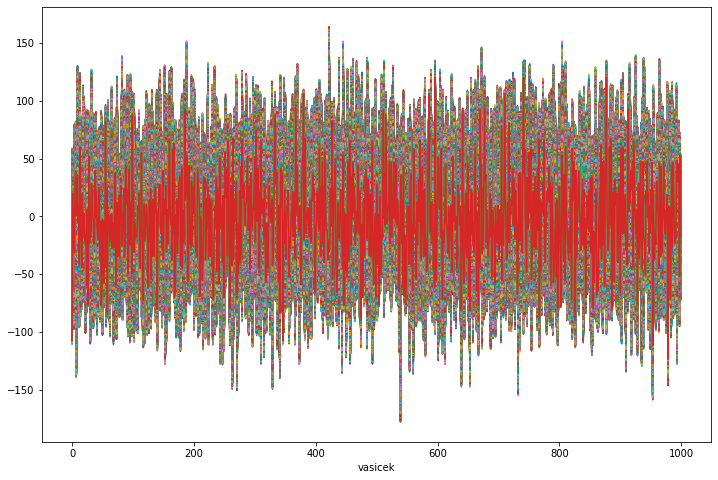

In [136]:
x = get_range_accr_price(
    upper_bound=8
    , low_bound=None
    , nominal=1000
    ,start='2020-12-15'
    ,end= '2021-12-31'
    
    , gran='hour'
    , res=res
    , appr=None
    , sim_num=1000
    , model='vasicek'
    , data=df

    , plot_show=True)